In [1]:
# import
import os, sys
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

# import plotting libraries
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 8})
plt.rcParams["svg.fonttype"] = "none"
import seaborn as sns
from nilearn import datasets
from nilearn import plotting

sys.path.extend([r'/home/lindenmp/research_projects/snaplab_tools'])
sys.path.extend([r'/home/lindenmp/research_projects/nctpy/src'])

# import nctpy functions
from snaplab_tools.plotting.plotting import categorical_kde_plot, reg_plot, brain_scatter_plot
from snaplab_tools.plotting.utils import get_my_colors, get_p_val_string
from nctpy.utils import matrix_normalization
from snaplab_tools.utils import get_schaefer_system_mask, get_null_p, get_fdr_p

from brainsmash.mapgen.base import Base

## Load data

In [2]:
# directory where data is stored
indir = '/home/lindenmp/research_projects/nct_xr/data'
which_data = 'HCPYA'
# which_data = 'MICS'
# which_data = 'macaque'
outdir = '/home/lindenmp/research_projects/nct_xr/results/{0}'.format(which_data)

atlas = 'Schaefer4007'
if atlas == 'Schaefer4007':
    n_parcels = 400
elif atlas == 'Schaefer2007':
    n_parcels = 200
elif atlas == 'Schaefer1007':
    n_parcels = 100
elif atlas == 'Markov':
    n_parcels = 182

In [3]:
adjacency = np.load(os.path.join(indir, '{0}_{1}_Am.npy'.format(which_data, atlas)))
adjacency_norm = matrix_normalization(adjacency, system='continuous')

In [4]:
eigenvalues, eigenvectors = np.linalg.eig(adjacency)
np.sort(np.abs(eigenvalues))[390:]

array([102.94368193, 128.2125259 , 147.11801793, 173.2179565 ,
       214.28557004, 239.35907813, 313.49606699, 369.47460691,
       429.94076576, 584.04728804])

In [5]:
eigenvalues, eigenvectors = np.linalg.eig(adjacency_norm)
np.sort(np.abs(eigenvalues))[390:]

array([1.05134593, 1.05252822, 1.05576871, 1.0581165 , 1.06231472,
       1.0692319 , 1.08016551, 1.08117758, 1.08747422, 1.12992691])

In [6]:
# extract cluster centers. These represent dominant patterns of recurrent activity over time
if which_data == 'macaque':
    parc_centroids = pd.read_csv(os.path.join(indir, 'macaque', 'MarkovCC12_M132_182-area.32k_fs_LR_mean_vertex.csv'), index_col=0)
else:
    parc_centroids = pd.read_csv(os.path.join(indir, 'Schaefer2018_{0}Parcels_7Networks_order_FSLMNI152_1mm.Centroid_RAS.csv'.format(n_parcels)), index_col=1)
    parc_centroids.drop(columns=['ROI Label'], inplace=True)
print(parc_centroids.head())

distance_matrix = distance.pdist(
    parc_centroids, "euclidean"
)  # get euclidean distances between nodes
distance_matrix = distance.squareform(distance_matrix)  # reshape to square matrix

                     R   A   S
ROI Name                      
7Networks_LH_Vis_1 -33 -42 -21
7Networks_LH_Vis_2 -30 -33 -18
7Networks_LH_Vis_3 -36 -62 -17
7Networks_LH_Vis_4 -24 -55  -8
7Networks_LH_Vis_5 -23 -73 -10


In [7]:
file_prefix = '{0}-{1}-Am_optimal-'.format(which_data, atlas)

if which_data == 'HCPYA':
    n_states = 7
elif which_data == 'MICS':
    n_states = 5
elif which_data == 'macaque':
    n_states = 4

c = 1
time_horizon = 1
rho = 1
reference_state = 'xf'
init_weights = 'one'
n_steps = 1000
lr = 0.01
eig_weight = 1.0
reg_weight = 0.0001
reg_type = 'l2'

file_str = '{0}optimized-energy_k-{1}_c-{2}_T-{3}_rho-{4}_refstate-{5}_initweights-{6}_nsteps-{7}_lr-{8}_eigweight-{9}_regweight-{10}_regtype-{11}'.format(file_prefix, 
                                                                                                                                                            n_states, 
                                                                                                                                                            c, time_horizon, rho,
                                                                                                                                                            reference_state, init_weights,
                                                                                                                                                            n_steps, lr, eig_weight, reg_weight, reg_type)
print(file_str)
log_args = np.load(os.path.join(outdir, file_str + '.npy'), allow_pickle=True).item()

control_energy_static_decay = log_args['control_energy_static_decay']
control_energy_variable_decay = log_args['control_energy_variable_decay']

print(log_args.keys())
print(control_energy_static_decay.shape, control_energy_variable_decay.shape)

HCPYA-Schaefer4007-Am_optimal-optimized-energy_k-7_c-1_T-1_rho-1_refstate-xf_initweights-one_nsteps-1000_lr-0.01_eigweight-1.0_regweight-0.0001_regtype-l2
dict_keys(['state_trajectory', 'control_signals', 'numerical_error', 'control_energy', 'loss', 'eigen_values', 'optimized_weights', 'state_trajectory_variable_decay', 'control_signals_variable_decay', 'numerical_error_variable_decay', 'control_energy_variable_decay', 'state_trajectory_static_decay', 'numerical_error_static_decay', 'control_energy_static_decay', 'control_signals_corr_partial', 'control_energy_partial', 'numerical_error_partial', 'xfcorr_partial', 'control_signals_corr_partial_variable_decay', 'control_energy_partial_variable_decay', 'numerical_error_partial_variable_decay', 'xfcorr_partial_variable_decay'])
(7, 7) (7, 7)


# Training

In [8]:
log_args['loss'].shape

(7, 7, 1000)

In [9]:
log_args['optimized_weights'].shape

(7, 7, 1000, 400)

In [10]:
eigen_vals_max = np.zeros((n_states, n_states, n_steps))
eigen_vals_var = np.zeros((n_states, n_states, n_steps))
eigen_vals_max[:] = np.nan
eigen_vals_var[:] = np.nan

for i in tqdm(np.arange(n_states)):
    for j in np.arange(n_states):
        try:
            idx = np.where(np.isnan(log_args['loss'][i, j]))[0][0] - 1
        except:
            idx = n_steps - 1

        for k in np.arange(idx):
            adjacency_sub = adjacency_norm - np.diag(log_args['optimized_weights'][i, j][k, :])
            eig = np.linalg.eigvalsh(adjacency_sub)
            eigen_vals_max[i, j, k] = np.max(eig)
            eigen_vals_var[i, j, k] = np.var(eig)

100%|██████████| 7/7 [01:34<00:00, 13.45s/it]


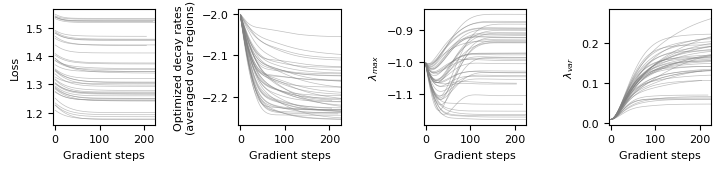

In [11]:
f, ax = plt.subplots(1, 4, figsize=(7.25, 1.75))
for i in np.arange(n_states):
    for j in np.arange(n_states):
        if i != j:
            ax[0].plot(log_args['loss'][i, j], c='gray', alpha=0.5, linewidth=0.5)
            x = -1 - log_args['optimized_weights'][i, j]
            ax[1].plot(x.mean(axis=1), c='gray', alpha=0.5, linewidth=0.5)
            ax[2].plot(eigen_vals_max[i, j], c='gray', alpha=0.5, linewidth=0.5)
            ax[3].plot(eigen_vals_var[i, j], c='gray', alpha=0.5, linewidth=0.5)
            
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Optimized decay rates\n(averaged over regions)')
ax[2].set_ylabel('$\lambda_{max}$')
ax[3].set_ylabel('$\lambda_{var}$')

for this_ax in ax:
    this_ax.set_xlabel('Gradient steps')
    this_ax.set_xlim([-5, 225])

f.tight_layout()
f.savefig(os.path.join(outdir, 'training.svg'), dpi=600, bbox_inches="tight", pad_inches=0.01)
plt.show()